In [1]:
print("""
@File         : ch09_adding_external_variables_to_our_model.ipynb
@Author(s)    : Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime  : 2024-04-05 12:20:11
@Email        : cuixuanstephen@gmail.com
@Description  : 
""")


@File         : ch09_adding_external_variables_to_our_model.ipynb
@Author(s)    : Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime  : 2024-04-05 12:20:11
@Email        : cuixuanstephen@gmail.com
@Description  : 



In [31]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
from typing import Union
import statsmodels.api as sm
from itertools import product

warnings.filterwarnings("ignore")
%matplotlib inline

## 检查 SARIMAX 模型

SARIMAX 模型通过添加外生变量的影响进一步扩展了 $SARIMA(p,d,q)(P,D,Q)_m$ 模型。因此，我们可以将现值 $y_t$ 简单地表示为 $SARIMA(p,d,q)(P,D,Q)_m$ 模型，在该模型中添加任意数量的外生变量 $X_t$：

$$y_t = SARIMA(p,d,q)(P,D,Q)_m+\sum_{i=1}^n\beta_iX_t^i$$

SARIMA 模型是线性模型，因为它是序列过去值和误差项的线性组合。这里我们添加了另一个不同外生变量的线性组合，导致 SARIMAX 也是一个线性模型。请注意，在 SARIMAX 中，您可以将分类变量包含为外生变量，但请确保对它们进行编码（为它们提供数值或二进制标志），就像对传统回归任务所做的那样。

SARIMAX 模型是预测时间序列的最通用模型。可以看到，如果没有季节性模式，它就变成了 ARIMAX 模型。在没有外生变量的情况下，它是 SARIMA 模型。如果没有季节性或外生变量，它成为 ARIMA 模型。

### 探索美国宏观经济数据集的外生变量

In [5]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


In [7]:
list(macro_econ_data.columns)

['year',
 'quarter',
 'realgdp',
 'realcons',
 'realinv',
 'realgovt',
 'realdpi',
 'cpi',
 'm1',
 'tbilrate',
 'unemp',
 'pop',
 'infl',
 'realint']

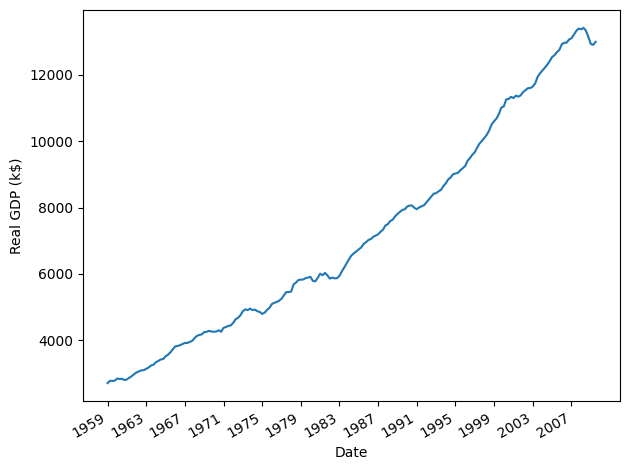

In [6]:
fig, ax = plt.subplots()
ax.plot(macro_econ_data["realgdp"])
ax.set_xlabel("Date")
ax.set_ylabel("Real GDP (k$)")
plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("figures/CH09_F01.png", dpi=300)

为了简单明了起见，我们在这里仅使用六个变量：实际 GDP（目标变量） 与后面的五个变量。

我们可以可视化每个变量随时间的变化情况，看看是否能够辨别出任何独特的模式。

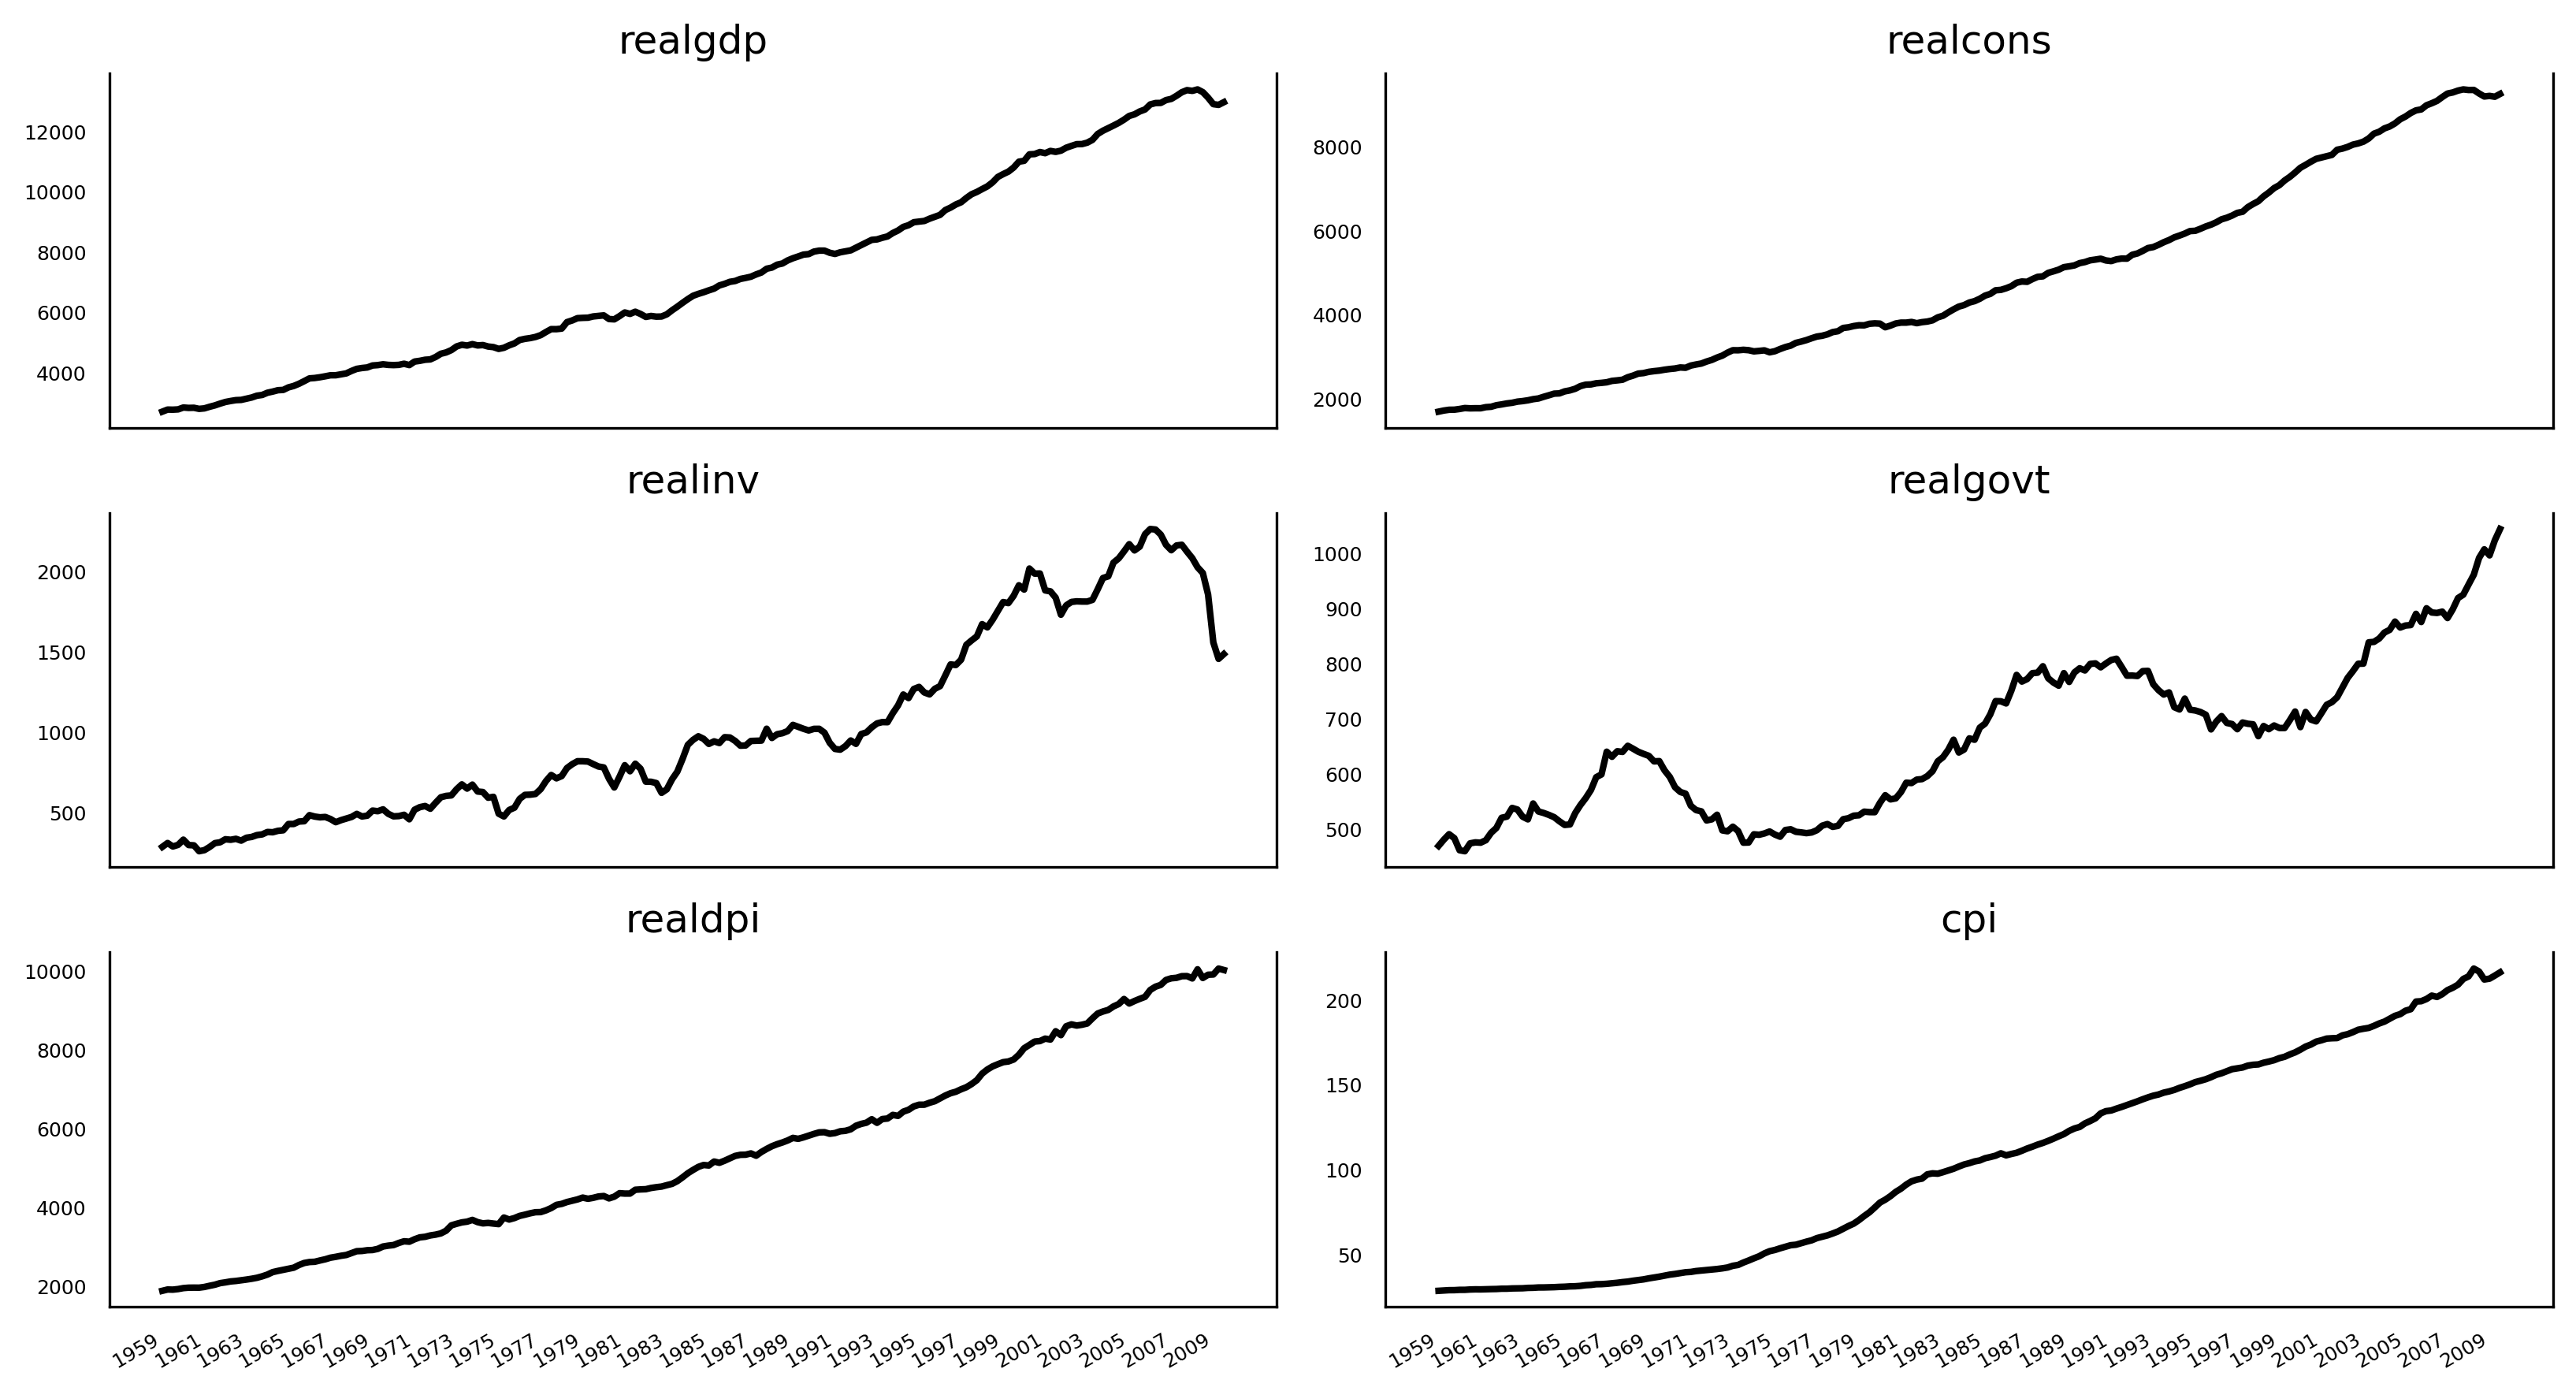

In [12]:
fig, axes = plt.subplots(3, 2, dpi=300, figsize=(11, 6))
for i, ax in enumerate(axes.ravel()):
    data = macro_econ_data[macro_econ_data.columns[i + 2]]
    ax.plot(data, color="black", linewidth=2)
    ax.set_title(macro_econ_data.columns[i + 2])
    ax.xaxis.set_ticks_position("none")
    ax.yaxis.set_ticks_position("none")
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.setp(axes, xticks=np.arange(0, 208, 8), xticklabels=np.arange(1959, 2010, 2))
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("figures/CH09_F02.png", dpi=300)

有两种方法可以使用外生变量进行时间序列预测。首先，我们可以使用各种外生变量组合来训练多个模型，并查看哪个模型可以生成最佳预测。或者，我们可以简单地包含所有外生变量并坚持使用 AIC 进行模型选择，因为我们知道这会产生一个不会过度拟合的良好拟合模型。

**为什么在回归分析中忽略 p 值？**

statsmodels 中的 SARIMAX 实现附带使用 `summary()` 方法的回归分析。

在该分析中，我们可以看到与 SARIMAX 模型的每个预测变量的每个系数相关的 p 值。p 值经常被滥用作为执行特征选择的一种方式。 许多人错误地将 p 值解释为确定预测变量是否与目标相关的一种方法。

事实上，p 值检验的是系数是否与 0 显着不同。如果 p 值小于0.05，那么我们拒绝原假设并得出系数 0 显着不同的结论。它并不能确定是否与 0 显着不同预测因子对于预测很有用。

因此，您不应根据 p 值删除预测变量。通过最小化 AIC 来选择模型即可完成该步骤。

要了解更多信息，我建议阅读 Rob Hyndman 的“[变量选择的统计检验](https://robjhyndman.com/hyndsight/tests2/)”博客文章。

### 使用 SARIMAX 的注意事项

回想一下，SARIMAX 模型使用 $SARIMA(p,d,q)(P,D,Q)_m$ 模型和外生变量的线性组合来预测未来的一个时间步长。但是如果您希望预测未来的两个时间步该怎么办？虽然 SARIMA 模型可以做到这一点，但 SARIMAX 模型也要求我们预测外生变量。

为了说明这个想法，我们假设 `realcons` 是 `realgdp` 的预测变量。还假设我们有一个 SARIMAX 模型，其中 `realcons` 用作输入特征来预测 `realgdp`。现在假设我们在 2009 年底，必须预测 2010 年和 2011 年的实际 GDP。SARIMAX 模型允许我们使用 2009 年的实数来预测 2010 年的实际 GDP。但是，预测 2011 年的实际 GDP 将需要我们无法预测 2010 年的真实数，除非我们等到 2010 年底才观察该值。

由于 `realcons` 变量本身就是一个时间序列，因此可以使用 SARIMA 模型的一个版本对其进行预测。尽管如此，我们知道我们的预测总是存在一些不可避免的错误。因此，必须预测外生变量来预测我们的目标变量会放大我们目标的预测误差，这意味着当我们预测未来更多的时间步长时，我们的预测可能会迅速变差。避免这种情况的唯一方法是仅预测未来的一个时间步长，并等待观察外生变量，然后再预测未来另一个时间步长的目标。

另一方面，如果你的外生变量很容易预测，这意味着它遵循可以准确预测的已知函数，那么预测外生变量并使用这些预测来预测目标就没有坏处。

最后，没有明确的建议来仅预测一个时间步长。这取决于情况和可用的外生变量，这就是你作为数据科学家的专业知识和严格的实验发挥作用的地方。如果你确定可以准确预测外生变量，则可以建议预测未来的许多时间步长。否则，你的建议必须是一次预测一个时间步骤，并通过解释随着进行更多预测，错误会累积，这意味着预测将失去准确性来证明你的决定的合理性。

![](../img/fig9-3.png)

*SARIMAX 模型的一般建模过程。该过程可以应用于任何问题，因为 SARIMAX 模型是最通用的预测模型，可以适应我们探索过的时间序列的所有不同过程和属性。*

In [28]:
target = macro_econ_data["realgdp"]
exog = macro_econ_data[["realcons", "realinv", "realgovt", "realdpi", "cpi"]]
ad_fuller_result = adfuller(target)
print(f"ADF Statistic: {ad_fuller_result[0]}")
print(f"p-value: {ad_fuller_result[1]}")

ADF Statistic: 1.7504627967647108
p-value: 0.9982455372335032


In [29]:
target_diff = np.diff(target)
ad_fuller_result = adfuller(target_diff)
print(f"ADF Statistic: {ad_fuller_result[0]}")
print(f"p-value: {ad_fuller_result[1]}")

ADF Statistic: -6.305695561658104
p-value: 3.327882187668259e-08


In [30]:
# from utils.optimize import optimize_SARIMAX

In [33]:
def optimize_SARIMAX(
    endog: Union[pd.Series, list],
    exog: Union[pd.Series, list],
    order_list: list,
    d: int,
    D: int,
    s: int,
) -> pd.DataFrame:
    results = []
    for order in tqdm(order_list):
        try:
            model = SARIMAX(
                endog,
                exog,  # Notice the addition of the exogenous variables when fitting the model.
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False,
            ).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ["(p,q,P,Q)", "AIC"]

    # Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)

    return result_df

In [34]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)

target_train = target[:200]
exog_train = exog[:200]
result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)

  0%|          | 0/256 [00:00<?, ?it/s]

100%|██████████| 256/256 [06:11<00:00,  1.45s/it]


In [35]:
result_df

,"(p,q,P,Q)",AIC
0,"(3, 3, 0, 0)",1742.824545
1,"(3, 3, 1, 0)",1744.965059
2,"(3, 3, 0, 1)",1745.000450
3,"(2, 2, 0, 0)",1745.476774
4,"(2, 2, 0, 1)",1746.003183
...,...,...
251,"(0, 2, 0, 0)",1761.579044
252,"(0, 3, 0, 0)",1762.317095
253,"(0, 0, 0, 0)",1764.754980
254,"(1, 0, 0, 0)",1765.379412


In [36]:
best_model = SARIMAX(
    target_train,
    exog_train,
    order=(3, 1, 3),
    seasonal_order=(0, 0, 0, 4),
    simple_differencing=False,
)
best_model_fit = best_model.fit(disp=False)
print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  200
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -859.412
Date:                Sat, 06 Apr 2024   AIC                           1742.825
Time:                        00:02:40   BIC                           1782.344
Sample:                             0   HQIC                          1758.819
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9708      0.045     21.496      0.000       0.882       1.059
realinv        1.0131      0.033     30.688      0.000       0.948       1.078
realgovt       0.7286      0.127      5.730      0.0

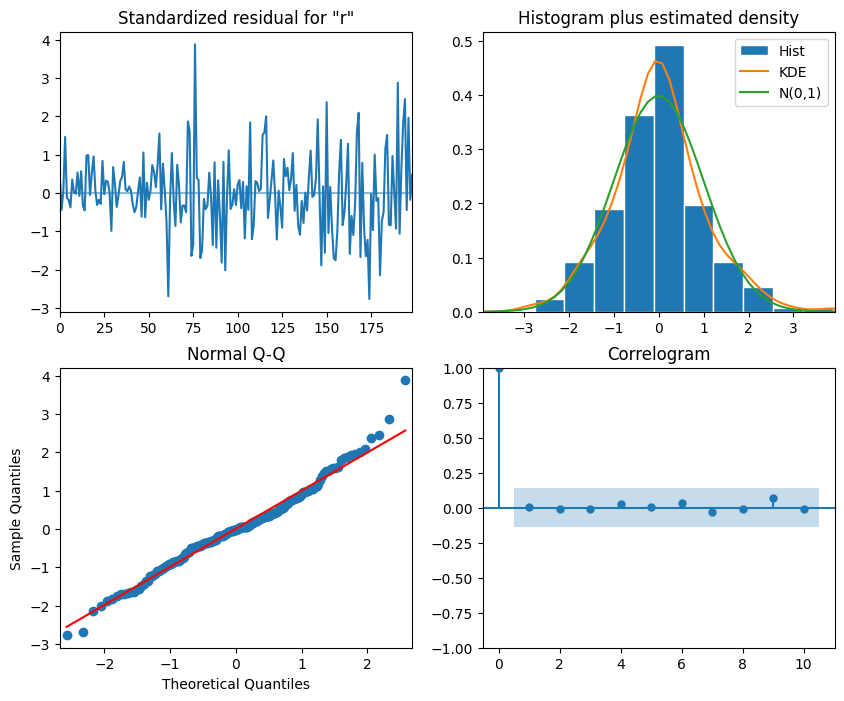

In [40]:
fig = best_model_fit.plot_diagnostics(figsize=(10, 8))

In [41]:
residuals = best_model_fit.resid
lb_result = acorr_ljungbox(residuals, np.arange(1, 11, 1))
lb_result

,lb_stat,lb_pvalue
1,0.091128,0.762748
2,0.197580,0.905933
3,0.199648,0.977646
4,1.258616,0.868357
5,1.259372,0.939056
6,1.286539,0.972395
7,1.477941,0.983064
8,1.487808,0.992908
9,1.861307,0.993476
10,1.868152,0.997254
